## Import the Model

In [1]:
import tensorflow as tf
from IPython import display

from tensorflow.python.keras.applications.vgg19 import VGG19

In [2]:
style = 'your_style_image'
content = 'your_content_image'

In [3]:
# VGG19 model
model = VGG19(
    include_top = False,
    weights = 'imagenet'
)

model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Import Libraries and Helper Functions

In [4]:
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Image Processing and Display

In [5]:
def load_and_process_image(image_path):
    img = load_img(image_path) # load image
    img = img_to_array(img)  # image to array
    img = preprocess_input(img) # preprocess show that VGG19 can accept
    img = np.expand_dims(img, axis=0)
    return img

In [6]:
def deprocess(x):
    # it is deprocessing of image show that it can be display there is no any library for that 
    # that why we are doing it manually
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def display_image(image):
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)
    
    img = deprocess(img)
    
    plt.grid(False)
    # plt.xticks([])
    # plt.yticks([])
    plt.axis('off')
    plt.imshow(img)
    return

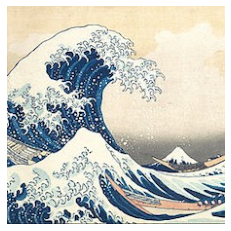

In [7]:
display_image(load_and_process_image(style))

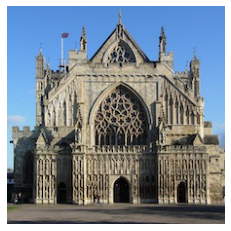

In [8]:
display_image(load_and_process_image(content))

## Content and Style Models

In [9]:
content_layer = 'block5_conv2'

style_layer = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]

content_model = Model(
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

style_models = [Model(inputs = model.input,
                    outputs = model.get_layer(layer).output) for layer in style_layer]

## Content Cost

In [10]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

## Gram Matrix

In [11]:
# It gives a strong feature correlation, it is uses to match feature distribution
def gram_matrix(A):
    n_C = int(A.shape[-1])
    a = tf.reshape(A, [-1, n_C])
    n = tf.shape(a)[0]
    G = tf.matmul(a, a, transpose_a = True)
    return G / tf.cast(n, tf.float32)

## Style Cost

In [12]:
# weighted sum of cost of each of the model
lam = 1. / len(style_models)

def style_cost(style, generated):
    J_style = 0
    
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        current_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += current_cost * lam
        
    return J_style

## Training Loop

In [13]:
import time
generated_images = []

def training_loop(content_path, style_path, iterations=10, alpha=10., beta=20.):
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    
    generated = tf.Variable(content, dtype=tf.float32)
    opt = tf.optimizers.Adam(learning_rate=7.)
    
    best_cost = 1e12 + 0.1  # initialize to high value
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = alpha * J_content + beta * J_style
            
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
            
        print('Cost after {} iterations: {}. Time elapsed: {}'.format(i, J_total, time.time() - start_time))
        display.clear_output(wait=True)
        generated_images.append(generated.numpy())
        
    return best_image

In [14]:
best_image = training_loop(content, style)

Cost after 9 iterations: 1825324672.0. Time elapsed: 2.849998950958252


## Plot the Results

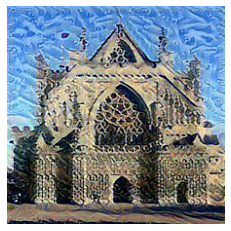

In [15]:
display_image(best_image)

In [16]:
# plt.figure(figsize=(10, 10))

# for i in range(20):
#     plt.subplot(5, 4, i+1)
#     display_image(generated_images[i])
    
# plt.show()